# 天池竞赛
链接：https://tianchi.aliyun.com/competition/entrance/531830/information

## 导入需要的包

In [104]:
# 从sklearn 调入所需要的包
# from sklearn import datasets

import os
import json
import gc
from numba import jit

from tqdm import tqdm_notebook
from tqdm import tqdm



import lightgbm as lgb

import catboost as cbt

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler as std
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import f1_score
import time
import datetime 
from datetime import datetime, timedelta
import gc
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
import scipy.spatial.distance as dist
from collections import Counter 
from statistics import mode 
import warnings
warnings.filterwarnings("ignore")
import json 
import math
from itertools import product
import ast
from sklearn.model_selection import train_test_split #数据分隔出训练集和验证集
import lightgbm as lgb
import numpy as np 
import pandas as pd
#导入精度和召回
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import lightgbm as lgb

import seaborn as sns
pd.set_option('display.max_columns',None)
%matplotlib inline

## 导入数据

In [258]:
train_data_file="./train.csv"
test_data_file="./testA.csv"

train_data = pd.read_csv(train_data_file)  #读取训练集
test_data = pd.read_csv(test_data_file)    #读取测试集

target=train_data['isDefault']             #label
train_data=train_data.drop(['isDefault'],axis=1)

In [259]:
data=pd.concat([train_data,test_data])  #合并数据
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 199999
Data columns (total 46 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1000000 non-null  int64  
 1   loanAmnt            1000000 non-null  float64
 2   term                1000000 non-null  int64  
 3   interestRate        1000000 non-null  float64
 4   installment         1000000 non-null  float64
 5   grade               1000000 non-null  object 
 6   subGrade            1000000 non-null  object 
 7   employmentTitle     999999 non-null   float64
 8   employmentLength    941459 non-null   object 
 9   homeOwnership       1000000 non-null  int64  
 10  annualIncome        1000000 non-null  float64
 11  verificationStatus  1000000 non-null  int64  
 12  issueDate           1000000 non-null  object 
 13  purpose             1000000 non-null  int64  
 14  postCode            999999 non-null   float64
 15  regionCode      

In [260]:
data.isnull().sum() #查看缺失值

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      58541
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
purpose                   0
postCode                  1
regionCode                0
dti                     300
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      521
revolBal                  0
revolUtil               658
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    50381
n1                    50381
n2                    50381
n3                    50381
n4                  

## 变量分类和缺失值处理

In [261]:
#object的变量  ==> objectList
#numerical的变量==>classList
#连续变量 ==>numericalList
objectList=[]
classList=[]
numericalList=[]
for i in train_data.columns:
    if train_data[i].dtype=='O':
        objectList.append(i)
for i in list(train_data.select_dtypes(exclude=['object']).columns):
    temp=train_data[i].unique()
    if len(temp)<=10:
        classList.append(i)
    else:
        numericalList.append(i)

In [263]:
info=pd.DataFrame(data.isnull().sum())
info=info[info[0] !=0]
miss_fea=info.index

In [264]:
miss_objectList=[i for i in miss_fea if i in objectList]
miss_classList=[i for i in miss_fea if i in classList]
miss_numericalList=[i for i in miss_fea if i in numericalList]

In [265]:
miss_objectList

['employmentLength']

In [266]:
data['employmentLength'].head()

0      2 years
1      5 years
2      8 years
3    10+ years
4          NaN
Name: employmentLength, dtype: object

In [267]:
# employmentLength 是就业时间 没有的填补为0
data['employmentLength'] = data['employmentLength'].fillna(0)

In [268]:
miss_classList

['n11', 'n12']

In [269]:
data['n11'] = data['n11'].fillna(0)
data['n12'] = data['n12'].fillna(0)

In [270]:
data['employmentTitle']=data['employmentTitle'].fillna(data['employmentTitle'].mode()[0])  #就业职称
data['postCode']=data['postCode'].fillna(data['postCode'].mode()[0])  #借款人在贷款申请中提供的邮政编码的前3位数字
data['dti']=data['dti'].fillna(data['postCode'].mean())            #债务收入比
data['pubRecBankruptcies']=data['pubRecBankruptcies'].fillna(data['pubRecBankruptcies'].mean()) #公开记录清除的数量
data['revolUtil']=data['revolUtil'].fillna(data['revolUtil'].mean())                       #循环额度利用率
data['title']=data['title'].fillna(data['title'].mode()[0])            #借款人提供的贷款名称
# 匿名变量
NoNameList=[i for i in miss_numericalList if i.startswith("n")]
for i in NoNameList:
    data[i]=data[i].fillna(data[i].mode()[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 199999
Data columns (total 46 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1000000 non-null  int64  
 1   loanAmnt            1000000 non-null  float64
 2   term                1000000 non-null  int64  
 3   interestRate        1000000 non-null  float64
 4   installment         1000000 non-null  float64
 5   grade               1000000 non-null  object 
 6   subGrade            1000000 non-null  object 
 7   employmentTitle     1000000 non-null  float64
 8   employmentLength    1000000 non-null  object 
 9   homeOwnership       1000000 non-null  int64  
 10  annualIncome        1000000 non-null  float64
 11  verificationStatus  1000000 non-null  int64  
 12  issueDate           1000000 non-null  object 
 13  purpose             1000000 non-null  int64  
 14  postCode            1000000 non-null  float64
 15  regionCode      

## object 变量处理

In [271]:
#object 变量处理
data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
data['employmentLength'].replace('0', '0 years', inplace=True)
def employmentLength_to_int(s):
    s=str(s)
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
    
data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [272]:
data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))
#issuedata 时间对分析意义不大 删除
data=data.drop(['issueDate'],axis=1)
train_data=train_data.drop(['issueDate'],axis=1)
test_data=test_data.drop(['issueDate'],axis=1)

In [273]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['grade']=le.fit_transform(data['grade'])
data['subGrade']=le.fit_transform(data['subGrade'])
data.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,earliesCreditLine,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,4,21,320.0,2,2,110000.0,2,1,137.0,32,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,2001,1.0,1.0,0.0,2.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,3,16,219843.0,5,0,46000.0,2,0,156.0,18,27.83,0.0,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,2002,1723.0,1.0,0.0,3.0,4.0,4.0,10.0,5.0,4.0,6.0,10.0,4.0,13.0,0.0,0.0,0.0,1.0
2,2,12000.0,5,16.99,298.17,3,17,31698.0,8,0,74000.0,2,0,337.0,14,22.77,0.0,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,2006,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,0,3,46854.0,10,1,118000.0,1,4,148.0,11,17.21,0.0,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,1999,4.0,1.0,6.0,4.0,6.0,6.0,4.0,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,4,3000.0,3,12.99,101.07,2,11,54.0,0,1,29000.0,2,10,301.0,21,32.16,0.0,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,1977,11.0,1.0,1.0,2.0,7.0,7.0,2.0,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


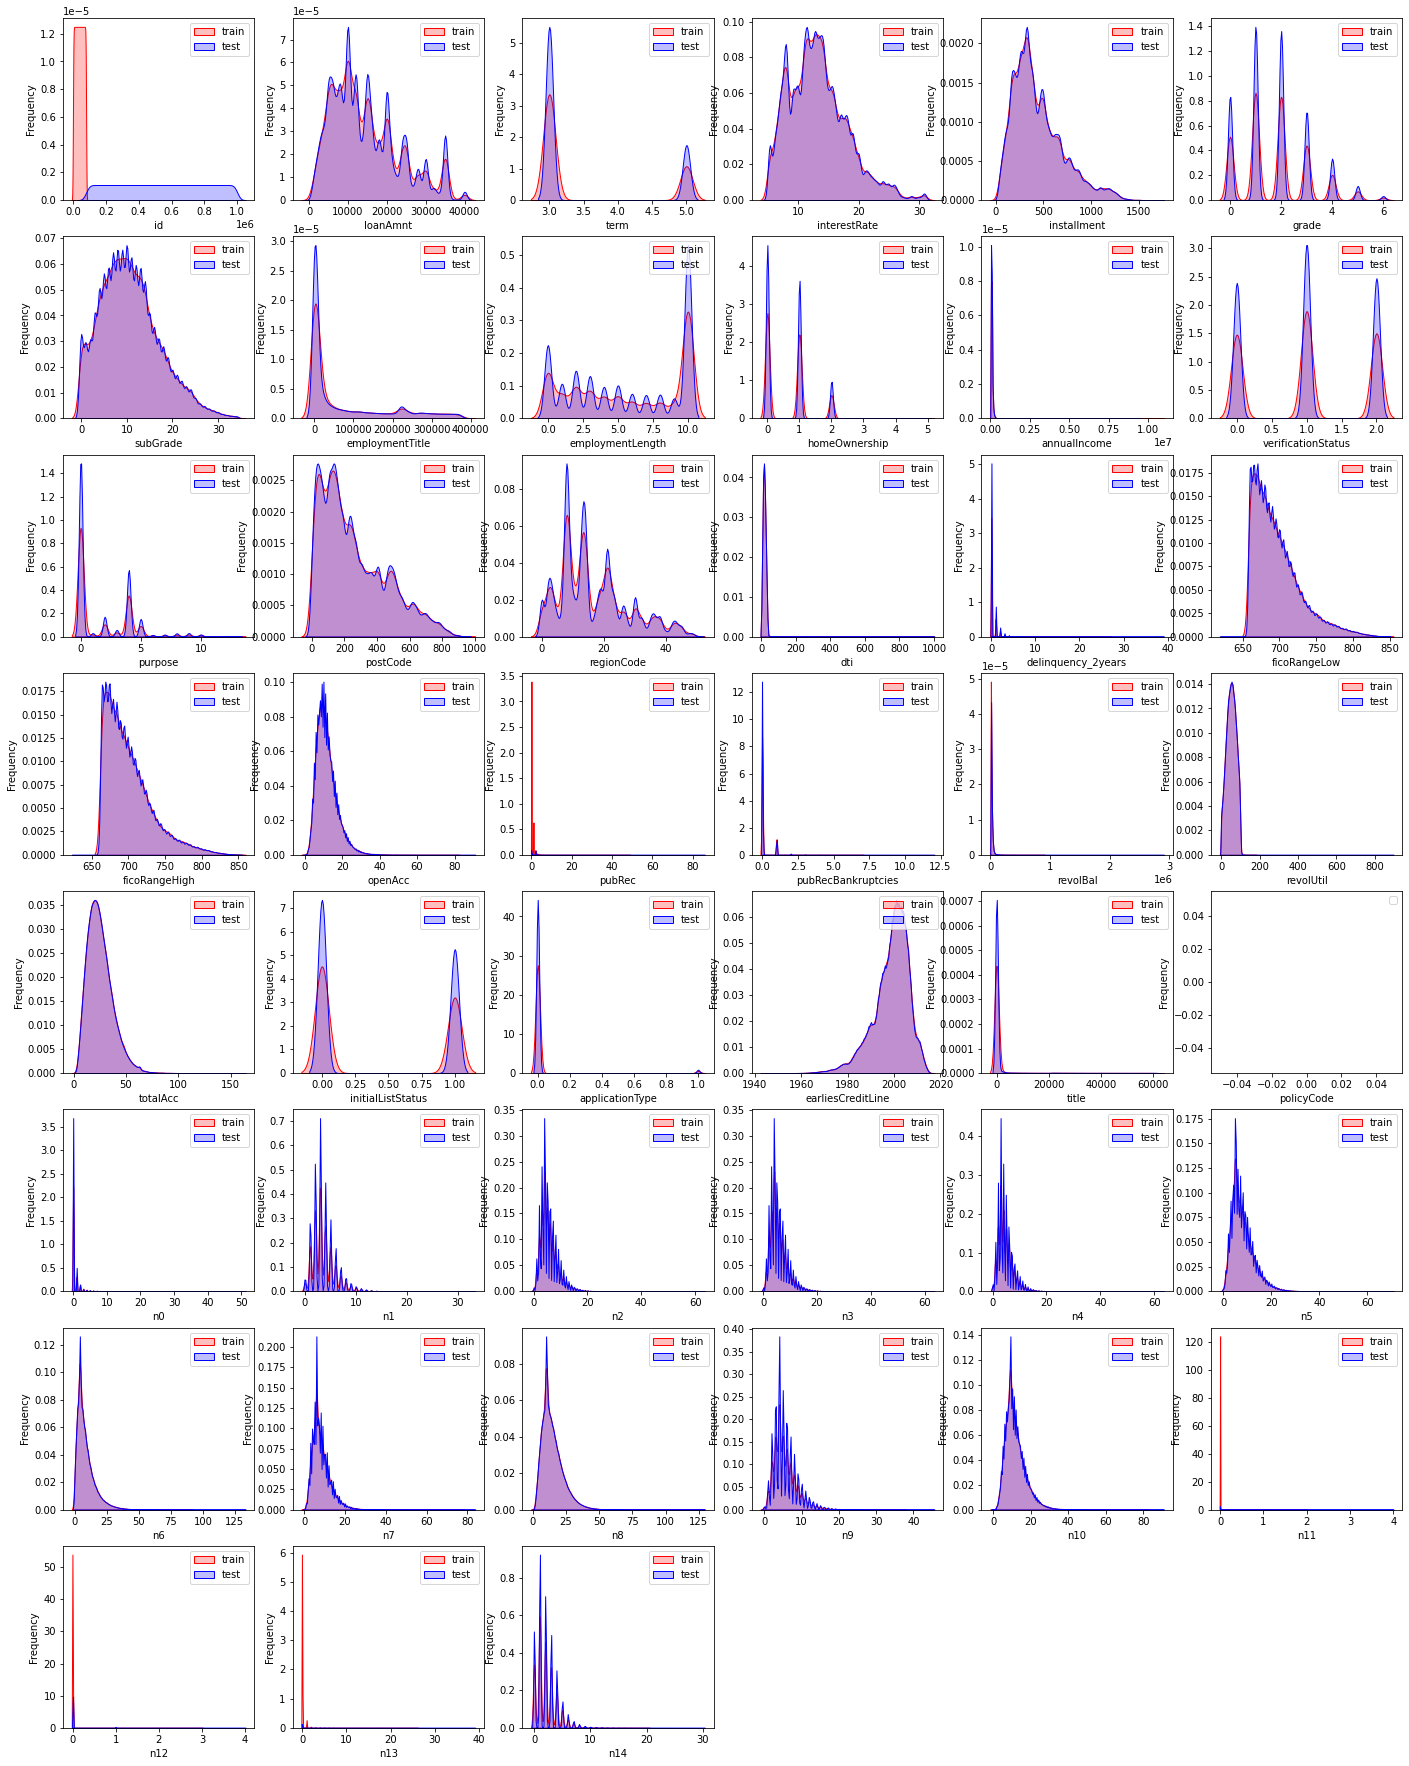

In [113]:
dist_cols=6
dist_rows=len(data.columns)
plt.figure(figsize=(4*6,4*dist_rows))
i=1
for col in data.columns:
    ax=plt.subplot(dist_rows,dist_cols,i)
    ax=sns.kdeplot(data[:80000][col],color="Red",shade=True)
    ax=sns.kdeplot(data[80000:][col],color="Blue",shade=True)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax=ax.legend(["train","test"])
    i+=1
plt.show()

In [274]:
dropList=['id','ficoRangeHigh','applicationType','policyCode','n3','n11','n12','n13']
data.drop(dropList,axis=1,inplace=True)

In [275]:
classList=[i for i in data.columns if len(data[i].value_counts())<=10]
classList

['term', 'grade', 'homeOwnership', 'verificationStatus', 'initialListStatus']

## 异常值处理

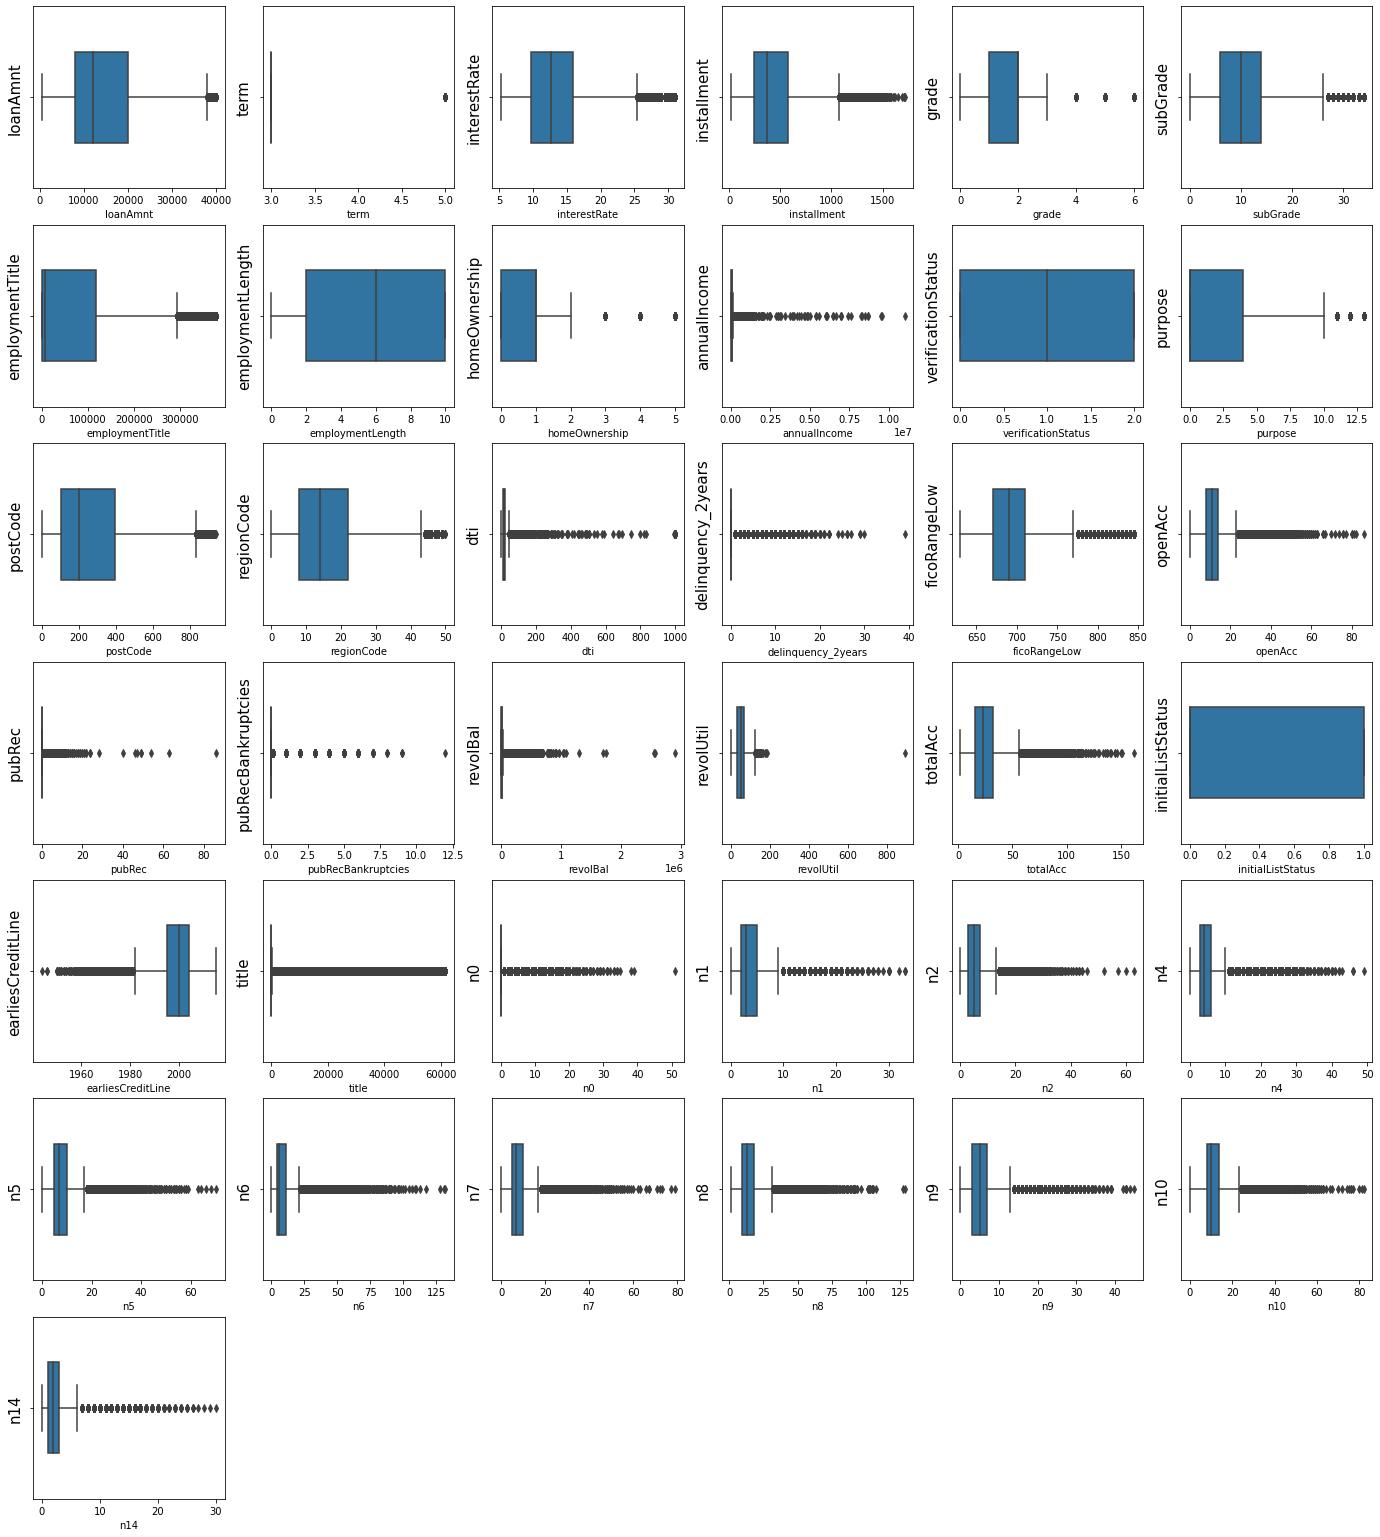

In [128]:

train_data=data[:800000]
column=train_data.columns.tolist()
dist_cols=6
dist_rows=len(column)
plt.figure(figsize=(4*6,4*len(column)))
i=1
for col in data.columns:
    plt.subplot(dist_rows,dist_cols,i)
    sns.boxplot(train_data[col],orient="v",width=0.5)
    plt.ylabel(col,fontsize=15)
    i+=1
plt.show()

In [132]:
import numpy as np
from scipy.stats import kstest
train_data['label']=target
classList=['term', 'grade', 'homeOwnership', 'verificationStatus', 'initialListStatus','label']
numList=[i for i in train_data.columns if i not in classList]
# 如果数据服从正太分布 则利用正态分布处理 
for i in numList:
    print(kstest(data[i], 'norm', (data[i].mean(), data[i].std())))
#都不符合正太分布
#pvalue>0.05 为正太分布

KstestResult(statistic=0.11806055878286709, pvalue=0.0)
KstestResult(statistic=0.06104710473554076, pvalue=0.0)
KstestResult(statistic=0.10049591367831434, pvalue=0.0)
KstestResult(statistic=0.07305806031941131, pvalue=0.0)
KstestResult(statistic=0.26850578326931024, pvalue=0.0)
KstestResult(statistic=0.20139951678993073, pvalue=0.0)
KstestResult(statistic=0.20427577663165858, pvalue=0.0)
KstestResult(statistic=0.3497739374112357, pvalue=0.0)
KstestResult(statistic=0.11702263072723768, pvalue=0.0)
KstestResult(statistic=0.156141433662279, pvalue=0.0)
KstestResult(statistic=0.08190059240282682, pvalue=0.0)
KstestResult(statistic=0.44824549766212163, pvalue=0.0)
KstestResult(statistic=0.1279774144876023, pvalue=0.0)
KstestResult(statistic=0.11329059607723663, pvalue=0.0)
KstestResult(statistic=0.46940130019588305, pvalue=0.0)
KstestResult(statistic=0.5137916753466008, pvalue=0.0)
KstestResult(statistic=0.23482735845566344, pvalue=0.0)
KstestResult(statistic=0.030456911847499324, pvalue=0

In [138]:
percentile=pd.DataFrame()
percentile['columns']=numList
dropList=[]
count=0
for i in tqdm(numList):
    count+=1
    deg=train_data[i]
    mean = np.mean(deg)
    var = np.var(deg)
    percentile = np.percentile(deg, (25, 50, 75), interpolation='midpoint')
    Q1 = percentile[0]#上四分位数
    Q3 = percentile[2]#下四分位数
    IQR = Q3 - Q1#四分位距
    ulim = Q3 + 1.5*IQR#上限 非异常范围内的最大值
    llim = Q1 - 1.5*IQR#下限 非异常范围内的最小值
    new_deg = []
    for i in range(len(deg)):
        if(llim<deg[i] and deg[i]<ulim):
            new_deg.append(deg[i])
    droppre=((len(deg)-len(new_deg))/len(deg))*100
    dropList.append(droppre)

100%|██████████| 32/32 [05:50<00:00, 10.96s/it]


NameError: name 'precentile' is not defined

In [161]:
dropList=[('%.4f' % i) for i in dropList]
percentile=pd.DataFrame([numList,dropList]).T
percentile[1]=percentile[1].map(lambda x:-1 if str(x)=='nan' else float(x))
judgeList=list(percentile[percentile[1]<=10][0])
judgeList

['loanAmnt',
 'interestRate',
 'installment',
 'subGrade',
 'employmentTitle',
 'employmentLength',
 'annualIncome',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'ficoRangeLow',
 'openAcc',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'earliesCreditLine',
 'n1',
 'n2',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n14']

In [247]:
train_data_1=train_data.copy()

In [248]:
#先数据正太化，再利用3σ原则剔除异常数据，反归一化即可还原数据
stdsc=StandardScaler()
drop_index=[]
for i in tqdm(numList):
    new_i="zheng_"+i
    train_data_1[new_i]=stdsc.c(train_data_1[i].values.reshape(-1,1))
    data_std = np.std(train_data_1[new_i])
    data_mean = np.mean(train_data_1[new_i])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    train_data_1=train_data_1.drop(train_data_1[(train_data_1[new_i])>ulim].index)
    train_data_1=train_data_1.drop(train_data_1[(train_data_1[new_i])<llim].index)
train_data_2=train_data_1.iloc[:,:38]
train_data_2.to_csv('正态分布训练集.csv',index=0)

100%|██████████| 32/32 [00:46<00:00,  1.44s/it]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 796024 entries, 0 to 799999
Data columns (total 70 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   loanAmnt                  796024 non-null  float64
 1   term                      796024 non-null  int64  
 2   interestRate              796024 non-null  float64
 3   installment               796024 non-null  float64
 4   grade                     796024 non-null  int64  
 5   subGrade                  796024 non-null  int64  
 6   employmentTitle           796024 non-null  float64
 7   employmentLength          796024 non-null  int64  
 8   homeOwnership             796024 non-null  int64  
 9   annualIncome              796024 non-null  float64
 10  verificationStatus        796024 non-null  int64  
 11  purpose                   796024 non-null  int64  
 12  postCode                  796024 non-null  float64
 13  regionCode                796024 non-null  i

## 建模炼丹

In [279]:
test_data=data[800000:]
test_data.to_csv("缺失值测试集.csv")

In [309]:
train_data_zt=train_data_2
train_data_zt.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,earliesCreditLine,title,n0,n1,n2,n4,n5,n6,n7,n8,n9,n10,n14,label
0,35000.0,5,19.52,917.97,4,21,320.0,2,2,110000.0,2,1,137.0,32,17.05,0.0,730.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,2001,1.0,0.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,2.0,1
1,18000.0,5,18.49,461.90,3,16,219843.0,5,0,46000.0,2,0,156.0,18,27.83,0.0,700.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,2002,1723.0,0.0,3.0,4.0,10.0,5.0,4.0,6.0,10.0,4.0,13.0,1.0,0
2,12000.0,5,16.99,298.17,3,17,31698.0,8,0,74000.0,2,0,337.0,14,22.77,0.0,675.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,2006,0.0,0.0,0.0,3.0,0.0,0.0,21.0,4.0,5.0,3.0,11.0,4.0,0
3,11000.0,3,7.26,340.96,0,3,46854.0,10,1,118000.0,1,4,148.0,11,17.21,0.0,685.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,1999,4.0,6.0,4.0,6.0,4.0,16.0,4.0,7.0,21.0,6.0,9.0,1.0,0
4,3000.0,3,12.99,101.07,2,11,54.0,0,1,29000.0,2,10,301.0,21,32.16,0.0,690.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,1977,11.0,1.0,2.0,7.0,2.0,4.0,9.0,10.0,15.0,7.0,12.0,4.0,0


In [281]:
label=train_data_zt['label']
train_data_zt=train_data_zt.drop('label',axis=1)
data=pd.concat([train_data_zt,test_data])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996024 entries, 0 to 199999
Data columns (total 37 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   loanAmnt            996024 non-null  float64
 1   term                996024 non-null  int64  
 2   interestRate        996024 non-null  float64
 3   installment         996024 non-null  float64
 4   grade               996024 non-null  int64  
 5   subGrade            996024 non-null  int64  
 6   employmentTitle     996024 non-null  float64
 7   employmentLength    996024 non-null  int64  
 8   homeOwnership       996024 non-null  int64  
 9   annualIncome        996024 non-null  float64
 10  verificationStatus  996024 non-null  int64  
 11  purpose             996024 non-null  int64  
 12  postCode            996024 non-null  float64
 13  regionCode          996024 non-null  int64  
 14  dti                 996024 non-null  float64
 15  delinquency_2years  996024 non-nul

In [385]:
datattt=x_train_gbdt
datattt['label']=y_train_gbdt
datattt=datattt.reset_index(drop=True)

In [386]:
x_train_gbdt=datattt.drop('label',axis=1)
y_train_gbdt=datattt['label']
x_test_bgdt=test_data
x_train_gbdt

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,earliesCreditLine,title,n0,n1,n2,n4,n5,n6,n7,n8,n9,n10,n14
0,35000.0,5,19.52,917.97,4,21,320.0,2,2,110000.0,2,1,137.0,32,17.05,0.0,730.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,2001,1.0,0.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,2.0
1,18000.0,5,18.49,461.90,3,16,219843.0,5,0,46000.0,2,0,156.0,18,27.83,0.0,700.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,2002,1723.0,0.0,3.0,4.0,10.0,5.0,4.0,6.0,10.0,4.0,13.0,1.0
2,12000.0,5,16.99,298.17,3,17,31698.0,8,0,74000.0,2,0,337.0,14,22.77,0.0,675.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,2006,0.0,0.0,0.0,3.0,0.0,0.0,21.0,4.0,5.0,3.0,11.0,4.0
3,11000.0,3,7.26,340.96,0,3,46854.0,10,1,118000.0,1,4,148.0,11,17.21,0.0,685.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,1999,4.0,6.0,4.0,6.0,4.0,16.0,4.0,7.0,21.0,6.0,9.0,1.0
4,3000.0,3,12.99,101.07,2,11,54.0,0,1,29000.0,2,10,301.0,21,32.16,0.0,690.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,1977,11.0,1.0,2.0,7.0,2.0,4.0,9.0,10.0,15.0,7.0,12.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796019,25000.0,3,14.49,860.41,2,13,2659.0,7,1,72000.0,0,0,242.0,8,19.03,0.0,710.0,14.0,0.0,0.0,9933.0,46.4,15.0,1,2011,0.0,0.0,5.0,10.0,6.0,6.0,2.0,12.0,13.0,10.0,14.0,3.0
796020,17000.0,3,7.90,531.94,0,3,29205.0,10,0,99000.0,2,4,563.0,10,15.72,1.0,720.0,7.0,0.0,0.0,20472.0,98.4,42.0,0,1989,33369.0,0.0,2.0,2.0,2.0,15.0,16.0,2.0,19.0,2.0,7.0,0.0
796021,6000.0,3,13.33,203.12,2,12,2582.0,10,1,65000.0,2,0,47.0,17,12.11,1.0,670.0,5.0,0.0,0.0,6381.0,51.9,36.0,1,2002,0.0,2.0,1.0,4.0,1.0,4.0,26.0,4.0,10.0,4.0,5.0,4.0
796022,19200.0,3,6.92,592.14,0,3,151.0,10,0,96000.0,2,4,34.0,18,29.25,0.0,675.0,16.0,0.0,0.0,69702.0,61.3,37.0,1,1994,4.0,0.0,5.0,8.0,7.0,10.0,6.0,12.0,22.0,8.0,16.0,5.0


## 基于LGB模型特征选择

In [392]:
import lightgbm
def select_by_lgb(train_data,train_label,random_state=2020,n_splits=5,metric='auc',num_round=10000,early_stopping_rounds=200):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = train_data.columns
    fold=0
    for train_idx, val_idx in kfold.split(train_data):
        random_state+=1
        train_x = train_data.loc[train_idx]
        train_y = train_label.loc[train_idx]
        test_x = train_data.loc[val_idx]
        test_y = train_label.loc[val_idx]
        clf=lightgbm
        train_matrix=clf.Dataset(train_x,label=train_y)
        test_matrix=clf.Dataset(test_x,label=test_y)
        params={
                'boosting_type': 'gbdt',  
                'objective': 'binary',
                'learning_rate': 0.1,
                'metric': metric,
                'seed': 2020,
                'nthread':-1 }
        model=clf.train(params,train_matrix,num_round,valid_sets=test_matrix,early_stopping_rounds=early_stopping_rounds)
        feature_importances['fold_{}'.format(fold + 1)] = model.feature_importance()
        fold+=1
    feature_importances['averge']=feature_importances[['fold_{}'.format(i) for i in range(1,n_splits+1)]].mean(axis=1)
    return feature_importances
        
feature_importances=select_by_lgb(x_train_gbdt,y_train_gbdt)


[LightGBM] [Info] Number of positive: 127263, number of negative: 509556
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3418
[LightGBM] [Info] Number of data points in the train set: 636819, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199842 -> initscore=-1.387284
[LightGBM] [Info] Start training from score -1.387284
[1]	valid_0's auc: 0.700447
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.702672
[3]	valid_0's auc: 0.704578
[4]	valid_0's auc: 0.705946
[5]	valid_0's auc: 0.706566
[6]	valid_0's auc: 0.707355
[7]	valid_0's auc: 0.708318
[8]	valid_0's auc: 0.709097
[9]	valid_0's auc: 0.709988
[10]	valid_0's auc: 0.710546
[11]	valid_0's auc: 0.711069
[12]	valid_0's auc: 0.711736
[13]	valid_0's auc: 0.712136
[14]	v

[258]	valid_0's auc: 0.729176
[259]	valid_0's auc: 0.729174
[260]	valid_0's auc: 0.729193
[261]	valid_0's auc: 0.729209
[262]	valid_0's auc: 0.729216
[263]	valid_0's auc: 0.729219
[264]	valid_0's auc: 0.729237
[265]	valid_0's auc: 0.729239
[266]	valid_0's auc: 0.729234
[267]	valid_0's auc: 0.72925
[268]	valid_0's auc: 0.729248
[269]	valid_0's auc: 0.729264
[270]	valid_0's auc: 0.729248
[271]	valid_0's auc: 0.72926
[272]	valid_0's auc: 0.729251
[273]	valid_0's auc: 0.729263
[274]	valid_0's auc: 0.729266
[275]	valid_0's auc: 0.729276
[276]	valid_0's auc: 0.729349
[277]	valid_0's auc: 0.729375
[278]	valid_0's auc: 0.729367
[279]	valid_0's auc: 0.729376
[280]	valid_0's auc: 0.72937
[281]	valid_0's auc: 0.729379
[282]	valid_0's auc: 0.729396
[283]	valid_0's auc: 0.72941
[284]	valid_0's auc: 0.729408
[285]	valid_0's auc: 0.729406
[286]	valid_0's auc: 0.72943
[287]	valid_0's auc: 0.729431
[288]	valid_0's auc: 0.729432
[289]	valid_0's auc: 0.729453
[290]	valid_0's auc: 0.72946
[291]	valid_0's 

[533]	valid_0's auc: 0.729822
[534]	valid_0's auc: 0.729815
[535]	valid_0's auc: 0.729812
[536]	valid_0's auc: 0.729818
[537]	valid_0's auc: 0.729814
[538]	valid_0's auc: 0.729824
[539]	valid_0's auc: 0.729821
[540]	valid_0's auc: 0.72983
[541]	valid_0's auc: 0.729831
[542]	valid_0's auc: 0.729816
[543]	valid_0's auc: 0.729832
[544]	valid_0's auc: 0.729847
[545]	valid_0's auc: 0.729838
[546]	valid_0's auc: 0.729831
[547]	valid_0's auc: 0.729826
[548]	valid_0's auc: 0.729826
[549]	valid_0's auc: 0.729832
[550]	valid_0's auc: 0.729823
[551]	valid_0's auc: 0.729835
[552]	valid_0's auc: 0.729824
[553]	valid_0's auc: 0.729825
[554]	valid_0's auc: 0.729818
[555]	valid_0's auc: 0.72981
[556]	valid_0's auc: 0.729802
[557]	valid_0's auc: 0.729802
[558]	valid_0's auc: 0.7298
[559]	valid_0's auc: 0.729784
[560]	valid_0's auc: 0.729768
[561]	valid_0's auc: 0.729763
[562]	valid_0's auc: 0.729748
[563]	valid_0's auc: 0.729755
[564]	valid_0's auc: 0.729751
[565]	valid_0's auc: 0.729752
[566]	valid_0'

[809]	valid_0's auc: 0.729958
[810]	valid_0's auc: 0.729954
[811]	valid_0's auc: 0.72995
[812]	valid_0's auc: 0.729946
[813]	valid_0's auc: 0.729941
[814]	valid_0's auc: 0.729949
[815]	valid_0's auc: 0.729966
[816]	valid_0's auc: 0.729952
[817]	valid_0's auc: 0.729956
[818]	valid_0's auc: 0.729943
[819]	valid_0's auc: 0.729966
[820]	valid_0's auc: 0.729974
[821]	valid_0's auc: 0.729954
[822]	valid_0's auc: 0.729944
[823]	valid_0's auc: 0.72993
[824]	valid_0's auc: 0.72993
[825]	valid_0's auc: 0.729923
[826]	valid_0's auc: 0.729918
[827]	valid_0's auc: 0.729942
[828]	valid_0's auc: 0.729969
[829]	valid_0's auc: 0.729961
[830]	valid_0's auc: 0.72996
[831]	valid_0's auc: 0.729972
[832]	valid_0's auc: 0.729972
[833]	valid_0's auc: 0.729976
[834]	valid_0's auc: 0.729963
[835]	valid_0's auc: 0.72997
[836]	valid_0's auc: 0.729949
[837]	valid_0's auc: 0.729946
[838]	valid_0's auc: 0.729929
[839]	valid_0's auc: 0.729923
[840]	valid_0's auc: 0.729922
[841]	valid_0's auc: 0.729903
[842]	valid_0's

[197]	valid_0's auc: 0.726367
[198]	valid_0's auc: 0.72635
[199]	valid_0's auc: 0.726341
[200]	valid_0's auc: 0.726338
[201]	valid_0's auc: 0.726339
[202]	valid_0's auc: 0.726365
[203]	valid_0's auc: 0.726376
[204]	valid_0's auc: 0.726366
[205]	valid_0's auc: 0.726368
[206]	valid_0's auc: 0.72639
[207]	valid_0's auc: 0.72641
[208]	valid_0's auc: 0.72642
[209]	valid_0's auc: 0.726431
[210]	valid_0's auc: 0.726455
[211]	valid_0's auc: 0.726452
[212]	valid_0's auc: 0.726435
[213]	valid_0's auc: 0.726462
[214]	valid_0's auc: 0.726462
[215]	valid_0's auc: 0.726438
[216]	valid_0's auc: 0.726474
[217]	valid_0's auc: 0.726485
[218]	valid_0's auc: 0.726486
[219]	valid_0's auc: 0.726499
[220]	valid_0's auc: 0.726507
[221]	valid_0's auc: 0.72649
[222]	valid_0's auc: 0.726512
[223]	valid_0's auc: 0.726498
[224]	valid_0's auc: 0.726493
[225]	valid_0's auc: 0.72648
[226]	valid_0's auc: 0.726518
[227]	valid_0's auc: 0.726535
[228]	valid_0's auc: 0.726546
[229]	valid_0's auc: 0.726574
[230]	valid_0's 

[472]	valid_0's auc: 0.727346
[473]	valid_0's auc: 0.727336
[474]	valid_0's auc: 0.72735
[475]	valid_0's auc: 0.727342
[476]	valid_0's auc: 0.727348
[477]	valid_0's auc: 0.727364
[478]	valid_0's auc: 0.727385
[479]	valid_0's auc: 0.727363
[480]	valid_0's auc: 0.727352
[481]	valid_0's auc: 0.727356
[482]	valid_0's auc: 0.727377
[483]	valid_0's auc: 0.727375
[484]	valid_0's auc: 0.727366
[485]	valid_0's auc: 0.727363
[486]	valid_0's auc: 0.727364
[487]	valid_0's auc: 0.727363
[488]	valid_0's auc: 0.727366
[489]	valid_0's auc: 0.727341
[490]	valid_0's auc: 0.72734
[491]	valid_0's auc: 0.727338
[492]	valid_0's auc: 0.727322
[493]	valid_0's auc: 0.72732
[494]	valid_0's auc: 0.727325
[495]	valid_0's auc: 0.727322
[496]	valid_0's auc: 0.727324
[497]	valid_0's auc: 0.727326
[498]	valid_0's auc: 0.727312
[499]	valid_0's auc: 0.727326
[500]	valid_0's auc: 0.727324
[501]	valid_0's auc: 0.727315
[502]	valid_0's auc: 0.72733
[503]	valid_0's auc: 0.727329
[504]	valid_0's auc: 0.727333
[505]	valid_0'

[LightGBM] [Info] Number of positive: 127146, number of negative: 509673
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3414
[LightGBM] [Info] Number of data points in the train set: 636819, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199658 -> initscore=-1.388433
[LightGBM] [Info] Start training from score -1.388433
[1]	valid_0's auc: 0.697894
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.701288
[3]	valid_0's auc: 0.702482
[4]	valid_0's auc: 0.703295
[5]	valid_0's auc: 0.703948
[6]	valid_0's auc: 0.704837
[7]	valid_0's auc: 0.70565
[8]	valid_0's auc: 0.706248
[9]	valid_0's auc: 0.707072
[10]	valid_0's auc: 0.707681
[11]	valid_0's auc: 0.708224
[12]	valid_0's auc: 0.708767
[13]	valid_0's auc: 0.709417
[14]	va

[259]	valid_0's auc: 0.727357
[260]	valid_0's auc: 0.727363
[261]	valid_0's auc: 0.727374
[262]	valid_0's auc: 0.727372
[263]	valid_0's auc: 0.727361
[264]	valid_0's auc: 0.727365
[265]	valid_0's auc: 0.727368
[266]	valid_0's auc: 0.727379
[267]	valid_0's auc: 0.727402
[268]	valid_0's auc: 0.727415
[269]	valid_0's auc: 0.727421
[270]	valid_0's auc: 0.727416
[271]	valid_0's auc: 0.72741
[272]	valid_0's auc: 0.727415
[273]	valid_0's auc: 0.727403
[274]	valid_0's auc: 0.727396
[275]	valid_0's auc: 0.727401
[276]	valid_0's auc: 0.7274
[277]	valid_0's auc: 0.727414
[278]	valid_0's auc: 0.727439
[279]	valid_0's auc: 0.727427
[280]	valid_0's auc: 0.727428
[281]	valid_0's auc: 0.727427
[282]	valid_0's auc: 0.727426
[283]	valid_0's auc: 0.72743
[284]	valid_0's auc: 0.727425
[285]	valid_0's auc: 0.727426
[286]	valid_0's auc: 0.727414
[287]	valid_0's auc: 0.727418
[288]	valid_0's auc: 0.727434
[289]	valid_0's auc: 0.727438
[290]	valid_0's auc: 0.727445
[291]	valid_0's auc: 0.72744
[292]	valid_0's

[536]	valid_0's auc: 0.727652
[537]	valid_0's auc: 0.727648
[538]	valid_0's auc: 0.727653
[539]	valid_0's auc: 0.727652
[540]	valid_0's auc: 0.727636
[541]	valid_0's auc: 0.727625
[542]	valid_0's auc: 0.727596
[543]	valid_0's auc: 0.727586
[544]	valid_0's auc: 0.727607
[545]	valid_0's auc: 0.727599
[546]	valid_0's auc: 0.727593
[547]	valid_0's auc: 0.727599
[548]	valid_0's auc: 0.727595
[549]	valid_0's auc: 0.727596
[550]	valid_0's auc: 0.727588
[551]	valid_0's auc: 0.727605
[552]	valid_0's auc: 0.727624
[553]	valid_0's auc: 0.727616
[554]	valid_0's auc: 0.727629
[555]	valid_0's auc: 0.727617
[556]	valid_0's auc: 0.727625
[557]	valid_0's auc: 0.72763
[558]	valid_0's auc: 0.727632
[559]	valid_0's auc: 0.727614
[560]	valid_0's auc: 0.727608
[561]	valid_0's auc: 0.727609
[562]	valid_0's auc: 0.727588
[563]	valid_0's auc: 0.7276
[564]	valid_0's auc: 0.727615
[565]	valid_0's auc: 0.727608
[566]	valid_0's auc: 0.727599
[567]	valid_0's auc: 0.727595
[568]	valid_0's auc: 0.727622
[569]	valid_0

[108]	valid_0's auc: 0.7243
[109]	valid_0's auc: 0.724315
[110]	valid_0's auc: 0.724318
[111]	valid_0's auc: 0.724377
[112]	valid_0's auc: 0.72438
[113]	valid_0's auc: 0.724399
[114]	valid_0's auc: 0.724443
[115]	valid_0's auc: 0.724481
[116]	valid_0's auc: 0.724479
[117]	valid_0's auc: 0.724515
[118]	valid_0's auc: 0.724539
[119]	valid_0's auc: 0.724566
[120]	valid_0's auc: 0.724599
[121]	valid_0's auc: 0.7246
[122]	valid_0's auc: 0.724609
[123]	valid_0's auc: 0.724641
[124]	valid_0's auc: 0.724704
[125]	valid_0's auc: 0.724772
[126]	valid_0's auc: 0.724841
[127]	valid_0's auc: 0.724859
[128]	valid_0's auc: 0.724859
[129]	valid_0's auc: 0.724938
[130]	valid_0's auc: 0.725029
[131]	valid_0's auc: 0.725036
[132]	valid_0's auc: 0.725043
[133]	valid_0's auc: 0.72513
[134]	valid_0's auc: 0.725142
[135]	valid_0's auc: 0.725182
[136]	valid_0's auc: 0.725211
[137]	valid_0's auc: 0.725231
[138]	valid_0's auc: 0.725247
[139]	valid_0's auc: 0.725235
[140]	valid_0's auc: 0.725246
[141]	valid_0's 

[384]	valid_0's auc: 0.727307
[385]	valid_0's auc: 0.727295
[386]	valid_0's auc: 0.727297
[387]	valid_0's auc: 0.727272
[388]	valid_0's auc: 0.727276
[389]	valid_0's auc: 0.727277
[390]	valid_0's auc: 0.727286
[391]	valid_0's auc: 0.727296
[392]	valid_0's auc: 0.727292
[393]	valid_0's auc: 0.727286
[394]	valid_0's auc: 0.727259
[395]	valid_0's auc: 0.727264
[396]	valid_0's auc: 0.727267
[397]	valid_0's auc: 0.727274
[398]	valid_0's auc: 0.727268
[399]	valid_0's auc: 0.727278
[400]	valid_0's auc: 0.727267
[401]	valid_0's auc: 0.727254
[402]	valid_0's auc: 0.727255
[403]	valid_0's auc: 0.72725
[404]	valid_0's auc: 0.727243
[405]	valid_0's auc: 0.727232
[406]	valid_0's auc: 0.727226
[407]	valid_0's auc: 0.727214
[408]	valid_0's auc: 0.727213
[409]	valid_0's auc: 0.727214
[410]	valid_0's auc: 0.727238
[411]	valid_0's auc: 0.727238
[412]	valid_0's auc: 0.727229
[413]	valid_0's auc: 0.727218
[414]	valid_0's auc: 0.727231
[415]	valid_0's auc: 0.727228
[416]	valid_0's auc: 0.727233
[417]	valid

[659]	valid_0's auc: 0.727511
[660]	valid_0's auc: 0.727502
[661]	valid_0's auc: 0.727496
[662]	valid_0's auc: 0.727491
[663]	valid_0's auc: 0.727508
[664]	valid_0's auc: 0.727523
[665]	valid_0's auc: 0.727523
[666]	valid_0's auc: 0.72752
[667]	valid_0's auc: 0.727516
[668]	valid_0's auc: 0.727511
[669]	valid_0's auc: 0.727517
[670]	valid_0's auc: 0.727515
[671]	valid_0's auc: 0.727524
[672]	valid_0's auc: 0.727532
[673]	valid_0's auc: 0.727532
[674]	valid_0's auc: 0.727534
[675]	valid_0's auc: 0.727546
[676]	valid_0's auc: 0.727544
[677]	valid_0's auc: 0.727541
[678]	valid_0's auc: 0.727529
[679]	valid_0's auc: 0.727521
[680]	valid_0's auc: 0.727502
[681]	valid_0's auc: 0.727508
[682]	valid_0's auc: 0.727499
[683]	valid_0's auc: 0.727498
[684]	valid_0's auc: 0.727492
[685]	valid_0's auc: 0.727495
[686]	valid_0's auc: 0.727506
[687]	valid_0's auc: 0.727507
[688]	valid_0's auc: 0.727495
[689]	valid_0's auc: 0.727495
[690]	valid_0's auc: 0.7275
[691]	valid_0's auc: 0.727494
[692]	valid_0

[934]	valid_0's auc: 0.727433
[935]	valid_0's auc: 0.727449
[936]	valid_0's auc: 0.727445
[937]	valid_0's auc: 0.727453
[938]	valid_0's auc: 0.727452
[939]	valid_0's auc: 0.727447
[940]	valid_0's auc: 0.727438
[941]	valid_0's auc: 0.727427
[942]	valid_0's auc: 0.727426
[943]	valid_0's auc: 0.727421
[944]	valid_0's auc: 0.727432
[945]	valid_0's auc: 0.727421
[946]	valid_0's auc: 0.727427
[947]	valid_0's auc: 0.727431
[948]	valid_0's auc: 0.727452
[949]	valid_0's auc: 0.727439
[950]	valid_0's auc: 0.727442
[951]	valid_0's auc: 0.727433
[952]	valid_0's auc: 0.72743
[953]	valid_0's auc: 0.727434
[954]	valid_0's auc: 0.727428
[955]	valid_0's auc: 0.727428
[956]	valid_0's auc: 0.727421
[957]	valid_0's auc: 0.727422
[958]	valid_0's auc: 0.727417
[959]	valid_0's auc: 0.727415
[960]	valid_0's auc: 0.72741
[961]	valid_0's auc: 0.727425
[962]	valid_0's auc: 0.727423
[963]	valid_0's auc: 0.727413
[964]	valid_0's auc: 0.727409
[965]	valid_0's auc: 0.727408
[966]	valid_0's auc: 0.727405
[967]	valid_

[183]	valid_0's auc: 0.730009
[184]	valid_0's auc: 0.730007
[185]	valid_0's auc: 0.730006
[186]	valid_0's auc: 0.730034
[187]	valid_0's auc: 0.730036
[188]	valid_0's auc: 0.730027
[189]	valid_0's auc: 0.73003
[190]	valid_0's auc: 0.730022
[191]	valid_0's auc: 0.73002
[192]	valid_0's auc: 0.730005
[193]	valid_0's auc: 0.730007
[194]	valid_0's auc: 0.730021
[195]	valid_0's auc: 0.730089
[196]	valid_0's auc: 0.73009
[197]	valid_0's auc: 0.730079
[198]	valid_0's auc: 0.730122
[199]	valid_0's auc: 0.730146
[200]	valid_0's auc: 0.730198
[201]	valid_0's auc: 0.73023
[202]	valid_0's auc: 0.730244
[203]	valid_0's auc: 0.730262
[204]	valid_0's auc: 0.730282
[205]	valid_0's auc: 0.730277
[206]	valid_0's auc: 0.730304
[207]	valid_0's auc: 0.730294
[208]	valid_0's auc: 0.730311
[209]	valid_0's auc: 0.730313
[210]	valid_0's auc: 0.730294
[211]	valid_0's auc: 0.730321
[212]	valid_0's auc: 0.730348
[213]	valid_0's auc: 0.730343
[214]	valid_0's auc: 0.730338
[215]	valid_0's auc: 0.730348
[216]	valid_0'

[457]	valid_0's auc: 0.730981
[458]	valid_0's auc: 0.730966
[459]	valid_0's auc: 0.730959
[460]	valid_0's auc: 0.730965
[461]	valid_0's auc: 0.730955
[462]	valid_0's auc: 0.730963
[463]	valid_0's auc: 0.730963
[464]	valid_0's auc: 0.730967
[465]	valid_0's auc: 0.730954
[466]	valid_0's auc: 0.730953
[467]	valid_0's auc: 0.730968
[468]	valid_0's auc: 0.730979
[469]	valid_0's auc: 0.730986
[470]	valid_0's auc: 0.730981
[471]	valid_0's auc: 0.730981
[472]	valid_0's auc: 0.730989
[473]	valid_0's auc: 0.730997
[474]	valid_0's auc: 0.731007
[475]	valid_0's auc: 0.730999
[476]	valid_0's auc: 0.730993
[477]	valid_0's auc: 0.73098
[478]	valid_0's auc: 0.730987
[479]	valid_0's auc: 0.730979
[480]	valid_0's auc: 0.730959
[481]	valid_0's auc: 0.730966
[482]	valid_0's auc: 0.730975
[483]	valid_0's auc: 0.730961
[484]	valid_0's auc: 0.730947
[485]	valid_0's auc: 0.730966
[486]	valid_0's auc: 0.730965
[487]	valid_0's auc: 0.730985
[488]	valid_0's auc: 0.730984
[489]	valid_0's auc: 0.73099
[490]	valid_

[733]	valid_0's auc: 0.731143
[734]	valid_0's auc: 0.731142
[735]	valid_0's auc: 0.731147
[736]	valid_0's auc: 0.731152
[737]	valid_0's auc: 0.731174
[738]	valid_0's auc: 0.731161
[739]	valid_0's auc: 0.731184
[740]	valid_0's auc: 0.731187
[741]	valid_0's auc: 0.731202
[742]	valid_0's auc: 0.731201
[743]	valid_0's auc: 0.731186
[744]	valid_0's auc: 0.731197
[745]	valid_0's auc: 0.731225
[746]	valid_0's auc: 0.731229
[747]	valid_0's auc: 0.731223
[748]	valid_0's auc: 0.731212
[749]	valid_0's auc: 0.731211
[750]	valid_0's auc: 0.731215
[751]	valid_0's auc: 0.73122
[752]	valid_0's auc: 0.73123
[753]	valid_0's auc: 0.731227
[754]	valid_0's auc: 0.731238
[755]	valid_0's auc: 0.73121
[756]	valid_0's auc: 0.731206
[757]	valid_0's auc: 0.731197
[758]	valid_0's auc: 0.731203
[759]	valid_0's auc: 0.731211
[760]	valid_0's auc: 0.731211
[761]	valid_0's auc: 0.73121
[762]	valid_0's auc: 0.731223
[763]	valid_0's auc: 0.731208
[764]	valid_0's auc: 0.731216
[765]	valid_0's auc: 0.731231
[766]	valid_0'

In [395]:
feature_importances['averge']=feature_importances[['fold_{}'.format(i) for i in range(1,6)]].mean(axis=1)
feature_importances

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,averge
0,loanAmnt,772,668,602,992,871,781.0
1,term,180,168,150,178,177,170.6
2,interestRate,1162,977,801,1344,1178,1092.4
3,installment,887,742,593,1111,973,861.2
4,grade,116,76,71,111,100,94.8
5,subGrade,394,347,309,452,453,391.0
6,employmentTitle,1262,1010,829,1432,1215,1149.6
7,employmentLength,469,379,357,606,498,461.8
8,homeOwnership,275,251,213,316,297,270.4
9,annualIncome,1221,1024,888,1563,1297,1198.6


## XGboost 贝叶斯调参

In [403]:
#x_train_gbdt,y_train_gbdt test_data
from xgboost import XGBClassifier

parameters = {
              'max_depth': [5, 10, 15, 20, 25],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              'n_estimators': [500, 1000, 2000, 3000, 5000],
              'min_child_weight': [0, 2, 5, 10, 20],
              'max_delta_step': [0, 0.2, 0.6, 1, 2],
              'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
              'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
              'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
              'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
              'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1]

}

xlf = xgb.XGBClassifier(max_depth=10,
            learning_rate=0.01,
            n_estimators=2000,
            silent=True,
            objective='binary:logistic',
            nthread=-1,
            gamma=0,
            min_child_weight=1,
            max_delta_step=0,
            subsample=0.85,
            colsample_bytree=0.7,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)
# 有了gridsearch我们便不需要fit函数
gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='roc_auc', cv=5,n_jobs=-1)
gsearch.fit(x_train_gbdt, y_train_gbdt)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


## lgb 贝叶斯优化

In [21]:
from bayes_opt import BayesianOptimization

In [404]:
train_x,val_x,train_y,val_y= train_test_split(x_train_gbdt,y_train_gbdt, test_size = 0.3, random_state = 42)

In [408]:
def LGB_bayesian(
    num_leaves,  # int
    min_data_in_leaf,  # int
    learning_rate,
    min_sum_hessian_in_leaf,    # int  
    feature_fraction,
    lambda_l1,
    lambda_l2,
    min_gain_to_split,
    max_depth):
    
    # LightGBM expects next three parameters need to be integer. So we make them integer
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int

    param = {
        'num_leaves': num_leaves,
        'max_bin': 63,
        'min_data_in_leaf': min_data_in_leaf,
        'learning_rate': learning_rate,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_gain_to_split': min_gain_to_split,
        'max_depth': max_depth,
        'save_binary': True, 
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'boost_from_average': False,   

    }    
    
    
    xg_train = lgb.Dataset(train_x,
                           label=train_y
                           )
    xg_valid = lgb.Dataset(val_x,
                           label=val_y
                           )   

    num_round = 5000
    clf = lgb.train(param, xg_train, num_round, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
    
    predictions = clf.predict(val_x, num_iteration=clf.best_iteration)   
    
    score = roc_auc_score(val_y, predictions)
    
    return score

In [409]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (5, 200), 
    'min_data_in_leaf': (5, 20),  
    'learning_rate': (0.01, 0.3),
    'min_sum_hessian_in_leaf': (0.00001, 0.01),    
    'feature_fraction': (0.05, 0.5),
    'lambda_l1': (0, 5.0), 
    'lambda_l2': (0, 5.0), 
    'min_gain_to_split': (0, 1.0),
    'max_depth':(3,20),
}

LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=13)

In [410]:
init_points = 5
n_iter = 20
print('-' * 130)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 111416, number of negative: 445800
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 557216, number of used features: 37
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.726762
|  1        |  0.7268   |  0.4      |  1.188  

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's auc: 0.72547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[750]	valid_0's auc: 0.726162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training beca

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2250]	valid_0's auc: 0.727448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are n

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

Training until validation scores don't improve for 50 rounds
[250]	valid_0's auc: 0.730048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Early stopping, best iteration is:
[356]	valid_0's auc: 0.730854
|  14       |  0.7309   |  0.3971   |  4

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training beca

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training beca

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[750]	valid_0's auc: 0.727727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's auc: 0.72738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Early stopping, best iteration is:
[873]	valid_0's auc: 0.727732
|  23       |  0.7277   |  0.1045   |  2.972    |  0.4104   |  0.1765   |  3.076    |  18.01    |  0.9852   |  0.001364 |  171.3    |
[LightGBM] [Info] Number of positive: 111416, number of negative: 445800
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 557216, number of used features: 37
Training unti

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 557216, number of used features: 37
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

In [411]:
LGB_BO.max['params']

{'feature_fraction': 0.3749082032826262,
 'lambda_l1': 0.17518262050718658,
 'lambda_l2': 1.492247354445897,
 'learning_rate': 0.026968622645801674,
 'max_depth': 17.570036023982382,
 'min_data_in_leaf': 10.592810418122113,
 'min_gain_to_split': 0.679847951578097,
 'min_sum_hessian_in_leaf': 0.002570236693773035,
 'num_leaves': 72.77833695473593}

In [412]:
LGB_BO.probe(
    params={'feature_fraction': 0.374, 
            'lambda_l1': 0.175, 
            'lambda_l2': 1.492, 
            'learning_rate': 0.026, 
            'max_depth': 17, 
            'min_data_in_leaf': 10, 
            'min_gain_to_split': 0.679, 
            'min_sum_hessian_in_leaf': 0.0025, 
            'num_leaves':72},
    lazy=True, # 
)

In [413]:
LGB_BO.maximize(init_points=0, n_iter=0) # remember no init_points or n_iter

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 111416, number of negative: 445800
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 557216, number of used features: 37
Training until validation scores don't improve for 50 rounds
[250]	valid_0's auc: 0.725511
[500]	valid_0's auc: 0.729246
[750]	valid_0's auc: 0.730193
[1000]	valid_0's auc: 0.730624
[1250]	valid_0's auc: 0.730937
Early stopping, best iteration is:
[1353]	valid_0's auc: 0.731012
|  26       |  0.731   

In [414]:
for i, res in enumerate(LGB_BO.res):
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': 0.7267621597233487, 'params': {'feature_fraction': 0.3999660847582191, 'lambda_l1': 1.1877061001745615, 'lambda_l2': 4.1213926633068425, 'learning_rate': 0.2900672674324699, 'max_depth': 19.534218936383187, 'min_data_in_leaf': 11.801738711259683, 'min_gain_to_split': 0.6090424627612779, 'min_sum_hessian_in_leaf': 0.007757509880902418, 'num_leaves': 130.1146022280185}}
Iteration 1: 
	{'target': 0.7313906114309567, 'params': {'feature_fraction': 0.3749082032826262, 'lambda_l1': 0.17518262050718658, 'lambda_l2': 1.492247354445897, 'learning_rate': 0.026968622645801674, 'max_depth': 17.570036023982382, 'min_data_in_leaf': 10.592810418122113, 'min_gain_to_split': 0.679847951578097, 'min_sum_hessian_in_leaf': 0.002570236693773035, 'num_leaves': 72.77833695473593}}
Iteration 2: 
	{'target': 0.7263038941018722, 'params': {'feature_fraction': 0.05423574653643624, 'lambda_l1': 1.7916689135248487, 'lambda_l2': 4.745470908391052, 'learning_rate': 0.07319071264818977, 'max

In [415]:
LGB_BO.max['target']

0.7313906114309567

In [416]:
LGB_BO.max['params']

{'feature_fraction': 0.3749082032826262,
 'lambda_l1': 0.17518262050718658,
 'lambda_l2': 1.492247354445897,
 'learning_rate': 0.026968622645801674,
 'max_depth': 17.570036023982382,
 'min_data_in_leaf': 10.592810418122113,
 'min_gain_to_split': 0.679847951578097,
 'min_sum_hessian_in_leaf': 0.002570236693773035,
 'num_leaves': 72.77833695473593}

In [417]:
param_lgb = {
        'num_leaves': int(LGB_BO.max['params']['num_leaves']), # remember to int here
        'max_bin': 63,
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']), # remember to int here
        'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'],
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': LGB_BO.max['params']['feature_fraction'],
        'lambda_l1': LGB_BO.max['params']['lambda_l1'],
        'lambda_l2': LGB_BO.max['params']['lambda_l2'],
        'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'],
        'max_depth': int(LGB_BO.max['params']['max_depth']), # remember to int here
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
        'force_row_wise':True
    }

In [423]:
#x_train_gbdt,y_train_gbdt test_data
nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=2019)
oof = np.zeros(len(x_train_gbdt))
predictions = np.zeros((len(test_data),nfold))

i = 1
for train_index, valid_index in skf.split(x_train_gbdt, y_train_gbdt):
    print("\nfold {}".format(i))
    xg_train = lgb.Dataset(x_train_gbdt.iloc[train_index].values,
                           label=y_train_gbdt[train_index].values,
                           )
    xg_valid = lgb.Dataset(x_train_gbdt.iloc[valid_index].values,
                           label=y_train_gbdt.iloc[valid_index].values,
                           )   

    
    clf = lgb.train(param_lgb, xg_train, 5000, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
    oof[valid_index] = clf.predict(x_train_gbdt.iloc[valid_index].values, num_iteration=clf.best_iteration) 
    
    predictions[:,i-1] += clf.predict(test_data, num_iteration=clf.best_iteration)
    i = i + 1




fold 1
[LightGBM] [Info] Number of positive: 127073, number of negative: 509746
[LightGBM] [Info] Total Bins 1446
[LightGBM] [Info] Number of data points in the train set: 636819, number of used features: 37
Training until validation scores don't improve for 50 rounds
[250]	valid_0's auc: 0.727418
[500]	valid_0's auc: 0.730858
[750]	valid_0's auc: 0.731683
[1000]	valid_0's auc: 0.732023
[1250]	valid_0's auc: 0.732173
Early stopping, best iteration is:
[1228]	valid_0's auc: 0.732196

fold 2
[LightGBM] [Info] Number of positive: 127073, number of negative: 509746
[LightGBM] [Info] Total Bins 1438
[LightGBM] [Info] Number of data points in the train set: 636819, number of used features: 37
Training until validation scores don't improve for 50 rounds
[250]	valid_0's auc: 0.725992
[500]	valid_0's auc: 0.729642
[750]	valid_0's auc: 0.730581
[1000]	valid_0's auc: 0.731008
[1250]	valid_0's auc: 0.731326
Early stopping, best iteration is:
[1423]	valid_0's auc: 0.73148

fold 3
[LightGBM] [Info]

NameError: name 'train_val_y' is not defined

In [424]:
print("\n\nCV AUC: {:<0.2f}".format(roc_auc_score(y_train_gbdt, oof)))



CV AUC: 0.73


In [429]:
result=pd.DataFrame(predictions)
result['averge']=result[[0,1,2,3,4]].mean(axis=1)
result

,0,1,2,3,4,averge
0,0.272991,0.258892,0.278189,0.250562,0.298357,0.271798
1,0.611084,0.618911,0.623578,0.598792,0.625485,0.615570
2,0.829817,0.831374,0.834658,0.831727,0.825011,0.830517
3,0.651382,0.625537,0.647343,0.639472,0.664283,0.645603
4,0.673154,0.673129,0.698241,0.656032,0.665235,0.673158
...,...,...,...,...,...,...
199995,0.402458,0.385805,0.374174,0.426469,0.439062,0.405593
199996,0.139657,0.132830,0.115628,0.116671,0.133431,0.127644
199997,0.462360,0.418306,0.453452,0.475121,0.426793,0.447206
199998,0.484776,0.509914,0.493642,0.500554,0.506215,0.499020


In [431]:
submit=pd.read_csv("sample_submit.csv")
submit['isDefault']=result['averge']
submit

,id,isDefault
0,800000,0.271798
1,800001,0.615570
2,800002,0.830517
3,800003,0.645603
4,800004,0.673158
...,...,...
199995,999995,0.405593
199996,999996,0.127644
199997,999997,0.447206
199998,999998,0.499020


In [432]:
submit.to_csv('submit.csv',index=0)